# Passion economy creator income data

In this notebook, I explore the distribution of income of Patreon and OnlyFans creators. 

The sources used for this research are [Graphtreon](https://graphtreon.com/) and [ranking-fans.com](https://ranking-fans.com) (NSFW). These sites aggregate data from Patreon and Onlyfans. With only a few API calls, I was able to gather income data for hundreds of thousands of creators.

This research was conducted for the [Good Data Initiative](https://www.gooddatainitiative.com/), a Cambridge-based think tank. It will be used in a review article on the passion economy, that will be published in October 2021. The idea to use raw data from these platforms to reach conclusions about inequalities and the distribution of wealth was largely inspired by Thomas Hollands' article [The Economics of Onlyfans](https://xsrus.com/the-economics-of-onlyfans). While the initial approach was basde on his [source code](https://github.com/ThomHollands/onlyfans) and the data he scraped, the final research does not use his dataset as it is too small (and biased towards popular creators).

In [1]:
import numpy as np
import os
import json
import requests
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
import scipy.stats

# Gathering patreon data

In [14]:
if not os.path.exists('patreon_json'):
    os.makedirs('patreon_json')
patreon_categories = np.array(["podcasts", "video", "games", "cosplay", "comics", "writing", "music", "adult-games", "adult-photography", "adult-video", "adult-cosplay", "animation", "drawing-painting", "photography", "crafts-diy", "dance-theater", "magazine", "3d-printing", "other", "adult-animation", "adult-comics", "adult-music", "adult-writing", "adult-drawing-painting", "adult-podcasts", "adult-crafts-diy", "adult-dance-theater", "adult-magazine", "adult-3d-printing", "adult-other"])

for category in patreon_categories:
    if not os.path.isfile('patreon_json/' + category + '.json'):
        print("Getting " + category)
        url = 'https://graphtreon.com/api/creators/' + category
        response = requests.get(url)

        with open('patreon_json/' + category + '.json', 'wb') as outf:
            outf.write(response.content)

In [15]:
patreon_list = []

for category in patreon_categories:
    f = open('patreon_json/' + category + '.json')
    this_json = json.load(f)
    f.close()
    this_data = this_json['data']
    for item in this_data:
        item['category']=category
    patreon_list += this_data

patreon_list

patreon = pd.DataFrame(patreon_list)
patreon.head()
patreon['earnings'] = patreon['earnings'] .str.replace("/month", "")
patreon['supportPerPatron'] = patreon['supportPerPatron'] .str.replace("/month", "")
patreon['patreonPublishedAt'] = pd.to_datetime(patreon['patreonPublishedAt'])

patreon = patreon[~patreon.earnings.str.contains("/",na=False)] # get rid of all non-monthly figures

patreon['earnings'] = patreon['earnings'].astype(float)
patreon['supportPerPatron'] = patreon['supportPerPatron'].astype(float)
patreon['daysRunning'] = patreon['daysRunning'].astype(int)

patreon = patreon[~patreon.earnings.isna()] # get rid of entries without income data
patreon[['link', 'name','description']] = patreon['link'].str.split('_&_', expand=True)

patreon = patreon.drop(columns='rank')

patreon=patreon.sort_values(by=['earnings'])
patreon.reset_index(drop=True, inplace=True)
cols = patreon.columns.tolist()
cols = [cols[0]] + cols[-2:] + cols[1:-2]
patreon=patreon[cols]

patreon


# patreon.describe()

,link,name,description,patrons,earnings,supportPerPatron,patreonPublishedAt,daysRunning,category
0,animaldrums,Mike F,water color paintings (animaldrums),1,0.09,0.09,2014-10-25 19:33:17,2507,drawing-painting
1,DRTDC90,DrTDC90,Chemistry Videos (DRTDC90),1,0.36,0.36,2016-01-13 03:54:23,2062,video
2,jherussell,Jhe Russell,"Art, Wisdom, Astrology, Syncretism and Love (j...",1,0.37,0.37,2018-10-28 18:48:56,1043,adult-dance-theater
3,FixItFrank,FixItFrank,Youtube Videos (FixItFrank),1,0.39,0.39,2018-08-31 17:47:09,1101,video
4,jayjackuncensored,Jay Jack Uncensored,Podcasts (jayjackuncensored)_adlt_,1,0.43,0.43,2015-04-10 21:55:34,2340,adult-podcasts
...,...,...,...,...,...,...,...,...,...
128551,Flagrant2,Flagrant 2,"Podcast, Video, and more (Flagrant2)",20271,97245.50,4.80,2018-10-01 19:40:24,1070,video
128552,adeptussteve,Adeptus Steve,Wild Life - An Adult RPG (adeptussteve)_adlt_,10064,103321.00,10.27,2016-04-03 11:27:15,1981,adult-games
128553,MitchRayTA,Technical Analysis with Mitch Ray,"Trade setups, livestreams, and trading educati...",988,112721.00,114.09,2018-07-13 02:02:53,1150,video
128554,chapotraphouse,Chapo Trap House,Chapo Trap House Podcast (chapotraphouse),35787,158736.00,4.44,2016-05-23 02:16:26,1931,podcasts


# Gathering Onlyfans data

In [16]:
if not os.path.exists('onlyfans_json'):
    os.makedirs('onlyfans_json')

for page in range(101+1):
    page=str(page)
    if not os.path.isfile('onlyfans_json/' + page + '.json'):
        print("Getting " + page)
        url = 'https://ranking-fans.com/wp-json/rf/v1/ofprofiles?page=' + page + '&sort=fans&order=0&size=1000&search='
        # headers = {'Accept': 'application/json'}
        # auth = ('username', 'userpass')
        response = requests.get(url)

        with open('onlyfans_json/' + page + '.json', 'wb') as outf:
            outf.write(response.content)



# last page is 101

    

In [17]:
onlyfans_list = []

for page in range(101+1):
    f = open('onlyfans_json/' + str(page) + '.json')
    this_json = json.load(f)
    f.close()
    onlyfans_list += this_json


onlyfans = pd.DataFrame(onlyfans_list)
onlyfans

,username,name,posts,likes,fans,sub_price,pic_url,offer,video,audio,photo,featured
0,suicidegirls,SuicideGirls,4100,2470000,155700,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
1,sarameikasaifree,Sara Mei Kasai,342,1080000,147300,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
2,scarlettmrose,Scarlett Rose ✪,376,277700,146000,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
3,calihotwifevip,MILF WIFE HOTWIFE,37,111100,140900,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
4,maryuofficial,Elf Horny SUPER SQUIRT 🧝‍♀️,755,285500,108800,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101985,bigbootymollygreenn,Molly Green,4,5,-1,20,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
101986,schoutenmax,Max,2,4,-1,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
101987,she.drips,She Drips,4,22,-1,20,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
101988,brittstyles32,Brittany Styles,8,14,-1,7,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0


# Pre-processing Onlyfans data

In [18]:
onlyfans = onlyfans.replace('-1', np.nan)
onlyfans = onlyfans.replace(-1, np.nan)
onlyfans = onlyfans.replace('Not found', np.nan)
onlyfans.describe()


# We drop all "free" alt accounts of influencers with paid accounts
onlyfans = onlyfans[~onlyfans.name.str.contains("free",case=False)]
onlyfans = onlyfans[~onlyfans.username.str.contains("free",case=False)]

onlyfans = onlyfans.drop(['name','pic_url','photo','video','audio'],1)
cols = onlyfans.columns

onlyfans[cols[1:]] = onlyfans[cols[1:]].apply(pd.to_numeric, errors='coerce')

In [19]:
onlyfans['likes_per_post'] = onlyfans['likes'] / onlyfans['posts'].astype(float,errors='ignore')
onlyfans['likes_per_post'] = onlyfans['likes_per_post'].replace([np.inf, -np.inf], 0)
# onlyfans['likes_per_post'] = onlyfans['likes_per_post'].fillna(0)
onlyfans['engagement_rate'] =  onlyfans['likes_per_post'] / onlyfans['fans']
onlyfans['engagement_rate'] = onlyfans['engagement_rate'].replace([np.inf, -np.inf], 0)


# Predicting missing Patreon data

A lot of Patreon accounts don't publish their earnings. We could try to guess it from their earnings and category, but unfortunately about 121 GiB of RAM is needed to fit a Gaussian process to this data.

# Predicting missing Onlyfans data

As only 3k of the ~100k creators in the OnlyFans dataset publish their fan count, and only 2k of those 3k publish their subscription price, we only have income data for ~2k creators. However, predicting the amount of fans from the average likes per post on these accounts should not be too difficult, as the amount of fans = (likes per post) / (engagement rate). The engagement rate can be relatively easily predicted from an account's features, and that can be used to calculate the amount of fans.

The engagement rate tends to hover amount a mean very low mean of only a few %. While we will probably undershoot/overshoot the engagement rate of some creators, on average, the predictions will make sense. This will allow us to describe the revenue of creators more accurately, as we will have many more data points.

The subscription price averages around $10, so setting all missing acounts to use this price should lead to accurate data. However, we can also try to predict the price as well. 

# Predicting the price for each creator

This might not work, as the sub price is not decided by the amount of likes and the likes per post and such (which the amount of fans was). Instead, it is decided by the creator before fans ever engage.

If this doesn't work, we can just use an avg price of $10.

However, because 2k of the 3k creators that publish fan data also publish their subscription price, and 80k out of the total 100k creators publish their subscription price, we do not need to do so. The data that we have is already enough.

C:\Users\freek\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\freek\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\freek\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value foun

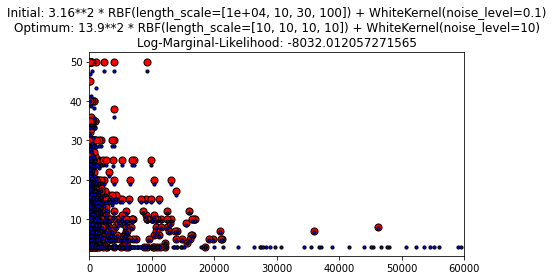

In [20]:
# multiple dimensions
mask = ~np.isnan(onlyfans.sub_price) & ~np.isnan(onlyfans.likes) & ~np.isnan(onlyfans.likes_per_post) & ~np.isnan(onlyfans.posts) & ~np.isnan(onlyfans.fans)
mask_2 = ~np.isnan(onlyfans.likes) & ~np.isnan(onlyfans.likes_per_post) & ~np.isnan(onlyfans.posts) & ~np.isnan(onlyfans.fans)
X = pd.DataFrame([onlyfans.likes[mask],onlyfans.likes_per_post[mask],onlyfans.posts[mask],onlyfans.fans[mask]]).T


y=np.array(onlyfans.sub_price[mask])
kernel =  10 * RBF(length_scale=[10000,10,30,100],length_scale_bounds=(10,10000)) + WhiteKernel(noise_level=0.1,noise_level_bounds=(1e-6,10))

gp = GaussianProcessRegressor(kernel=kernel).fit(X, y)
xlim=60000      
X_ = pd.DataFrame([onlyfans.likes[mask_2],onlyfans.likes_per_post[mask_2],onlyfans.posts[mask_2],onlyfans.fans[mask_2]]).T                        


plt.scatter(onlyfans.likes[mask], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
means, sigmas = gp.predict(X_,return_std=True)

myclip_a=3 
myclip_b=np.inf

# Y_ = np.random.normal(means,sigmas)
Y_ = means

# a, b = (myclip_a - means) / sigmas, (myclip_b - means) / sigmas
# Y_ = np.array([scipy.stats.truncnorm.stats(a[i], b[i], loc=means[i],scale=sigmas[i],moments='m') for i in range(len(means))])

Y_ = np.clip(Y_,myclip_a,None)
plt.scatter(onlyfans.likes[mask_2], Y_, c='b', s=10, zorder=10, edgecolors=(0, 0, 0))
plt.xlim(0,xlim)
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# gp.predict([[100]])
price_pred = Y_


price_pred_spaced_out = onlyfans.sub_price.copy(deep=True)
price_pred_spaced_out[:] = np.nan
price_pred_spaced_out[mask_2] = price_pred

price_pred_full = onlyfans.sub_price.copy(deep=True)
price_pred_full[onlyfans.sub_price.isna()] = price_pred_spaced_out[onlyfans.sub_price.isna()]

price_pred = price_pred_full

# ((gp.predict(X)  - y)**2).mean() 





In [21]:
# Just set empty prices to $10, the median (but below the mean)


onlyfans['sub_price'] = price_pred
onlyfans.sub_price = onlyfans.sub_price.round()

onlyfans.sub_price.describe()

count    81074.000000
mean        12.054012
std          8.158148
min          3.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        100.000000
Name: sub_price, dtype: float64

# Predicting the engagement rate from multiple variables

Instead of just using likes, we can use the likes, like per posts, and amount of posts together.
We can use this to predict the amount of fans later (indirectly).

In [22]:

mask = ~np.isnan(onlyfans.likes) & ~np.isnan(onlyfans.posts) & ~np.isnan(onlyfans.engagement_rate)
mask_2 = ~np.isnan(onlyfans.likes) &  ~np.isnan(onlyfans.posts)
X = pd.DataFrame([onlyfans.likes[mask],onlyfans.posts[mask]]).T

y=np.array(onlyfans.engagement_rate[mask])

# kernel = 0.01 * RBF(length_scale=[10000,10,150],length_scale_bounds=(1e-6,1.47e+12)) + WhiteKernel(noise_level=5)
kernel =  0.01 * RBF(length_scale=[1000000,150],length_scale_bounds=(30,1.47e12)) + WhiteKernel(noise_level=0.1,noise_level_bounds=(1e-6,0.3)) + DotProduct()

gp = GaussianProcessRegressor(kernel=kernel).fit(X, y)
xlim=600000      
X_ = pd.DataFrame([onlyfans.likes[mask_2],onlyfans.posts[mask_2]]).T                        
means, sigmas = gp.predict(X_,return_std=True)

myclip_a=0.005
myclip_b=np.inf

# Y_ = np.random.normal(means,sigmas)
Y_ = means

# a, b = (myclip_a - means) / sigmas, (myclip_b - means) / sigmas
# Y_ = np.array([scipy.stats.truncnorm.stats(a[i], b[i], loc=means[i],scale=sigmas[i],moments='m') for i in range(len(means))])

engagement_rate_pred_jittery = np.clip(Y_,myclip_a,None)




C:\Users\freek\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 30.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\freek\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k1__k2__length_scale is close to the specified lower bound 30.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\freek\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 0.3. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optima

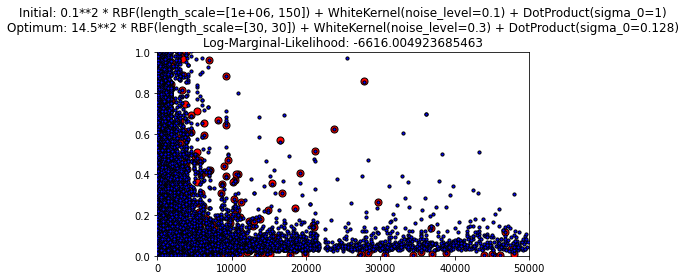

In [23]:

plt.scatter(onlyfans.likes[mask], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.xlim(0,50000)
plt.ylim(0,1)
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

plt.scatter(onlyfans.likes[mask_2], engagement_rate_pred_jittery, c='b', s=10, zorder=10, edgecolors=(0, 0, 0))




engagement_rate_pred_jittery_spaced_out = onlyfans.engagement_rate.copy(deep=True)
engagement_rate_pred_jittery_spaced_out[:] = np.nan
engagement_rate_pred_jittery_spaced_out[mask_2] = engagement_rate_pred_jittery

engagement_rate_pred_jittery_full = onlyfans.engagement_rate.copy(deep=True)
engagement_rate_pred_jittery_full[onlyfans.engagement_rate.isna()] = engagement_rate_pred_jittery_spaced_out[onlyfans.engagement_rate.isna()]

engagement_rate_pred_jittery = engagement_rate_pred_jittery_full

indirect_pred_jittery = (onlyfans.likes_per_post/engagement_rate_pred_jittery)
indirect_pred_jittery = indirect_pred_jittery.replace([np.inf, -np.inf], 0)


# Calculating which fans prediction is best

In [24]:
((indirect_pred_jittery[mask]  - onlyfans.fans[mask])**2).mean() # good mse at 219k. median good at 0.029, mean good at 0.0624. max good at 0.67

indirect_pred_jittery.describe()



count    6.967400e+04
mean     6.073235e+02
std      1.880079e+04
min      5.159032e-03
25%      3.813167e+00
50%      5.881018e+00
75%      1.389906e+01
max      2.474708e+06
dtype: float64

# Predicting the amount of fans for all creators

In [25]:
# UNCOMMENT to predict fans for all 100k creators. Leave commented to just use the 3k creators that publish fans.

onlyfans.engagement_rate = engagement_rate_pred_jittery
onlyfans.fans = indirect_pred_jittery

onlyfans.fans = onlyfans.fans.round()
onlyfans.fans = onlyfans.fans.replace([np.inf, -np.inf], np.nan)


In [26]:
# new_mask2.values.sum()
# new_mask.values.sum()


# Calculating Onlyfans revenue

In [27]:
# monthly revenue
onlyfans['revenue'] = onlyfans['sub_price'] * onlyfans['fans']

onlyfans=onlyfans.sort_values(by=['revenue'])
onlyfans.reset_index(drop=True, inplace=True)


# Plots

In [28]:


patreon.to_csv('patreon.csv',index=False)
patreon.describe().round(2)

,patrons,earnings,supportPerPatron,daysRunning
count,128556.00,128556.00,128556.00,128556.00
mean,32.53,178.44,6.93,817.24
std,262.60,1314.61,10.34,632.25
min,1.00,0.09,0.06,0.00
25%,2.00,8.42,2.85,316.00
50%,5.00,26.79,4.60,653.00
75%,15.00,96.68,8.12,1176.00
max,35787.00,172831.00,920.70,3043.00


In [29]:
onlyfans.to_csv('onlyfans.csv',index=False)
onlyfans.describe().round(2)

,posts,likes,fans,sub_price,offer,featured,likes_per_post,engagement_rate,revenue
count,100254.00,69674.00,69674.00,81074.00,100254.00,100254.00,69674.00,69674.00,56025.00
mean,68.28,4536.68,607.34,12.05,1.24,0.00,14.03,0.59,2696.07
std,315.14,56823.63,18800.79,8.16,8.15,0.01,115.40,1.15,27315.15
min,1.00,1.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00
25%,4.00,13.00,4.00,6.00,0.00,0.00,1.33,0.20,40.00
50%,11.00,75.00,6.00,10.00,0.00,0.00,3.39,0.43,72.00
75%,38.00,436.00,14.00,15.00,0.00,0.00,8.60,0.68,180.00
max,18300.00,4000000.00,2474708.00,100.00,90.00,1.00,12373.54,56.16,3564000.00


In [2]:
onlyfans = pd.read_csv("onlyfans.csv")
patreon=pd.read_csv("patreon.csv")


In [3]:
patreon2 = patreon.copy(deep=True)
patreon2 = patreon2.drop(['link','description','daysRunning','patreonPublishedAt','category'],axis=1)
patreon2.columns = ['name','fans','income','income_per_fan']
patreon2['platform'] = 'Patreon'
# patreon2

onlyfans2=onlyfans.copy(deep=True)
onlyfans2 = onlyfans2.drop(['posts','likes','offer','featured','engagement_rate','likes_per_post'],axis=1)
onlyfans2 = onlyfans2[onlyfans2.columns[[0,1,3,2]]]
onlyfans2.columns = ['name','fans','income','income_per_fan']
onlyfans2['platform'] = 'Onlyfans'

# combine the datasets so that we can plot joint figures
combined = pd.concat([onlyfans2,patreon2],axis=0,ignore_index=True)

# shuffle this dataset, because otherwise all onlyfans dots are drawn in front of the patreon dots, hiding the other dataset.
# remove and re-add the first row after shuffling to make sure an onlyfans row always comes first (to ensure onlyfans is always blue, patreon is always orange)
first_row = combined.loc[0]
combined.drop(0, inplace=True)
combined_shuffled = combined.sample(frac=1).reset_index(drop=True) 
combined_shuffled = pd.concat([first_row,combined_shuffled])

combined = pd.concat([first_row,combined])


Text(0, 0.5, '% of Creators')

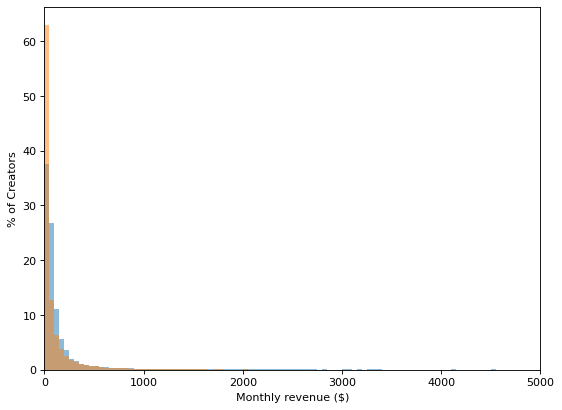

In [4]:
# a_length = onlyfans.revenue.dropna().size
# a = 100*(a/a_length)
from matplotlib.pyplot import figure
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
onlyfans_color = colors[0]
patreon_color=colors[1]

figure(figsize=(8, 6), dpi=80)

width=50
xlim = 5000
hist1, bins1 = np.histogram(onlyfans.revenue.dropna(),bins=range(0,xlim+width,width))
plt.bar(bins1[:-1],100*hist1.astype(np.float32) / hist1.sum(), width=(width),color=onlyfans_color,alpha=0.5,align='edge')

hist2, bins2 = np.histogram(patreon.earnings.dropna(),bins=range(0,xlim+width,width))
plt.bar(bins2[:-1],100*hist2.astype(np.float32) / hist2.sum(), width=(width),color=patreon_color,alpha=0.5,align='edge')

# a.plot(kind='hist',bins=500,xlim=(0,10000),density=True)
# patreon.earnings.dropna().plot(kind='hist',bins=500,xlim=(0,10000))
plt.xlabel('Monthly revenue ($)')
plt.xlim(0,xlim)
plt.ylabel('% of Creators')

# plt.ylim(0,200)

Text(0, 0.5, '% of Creators')

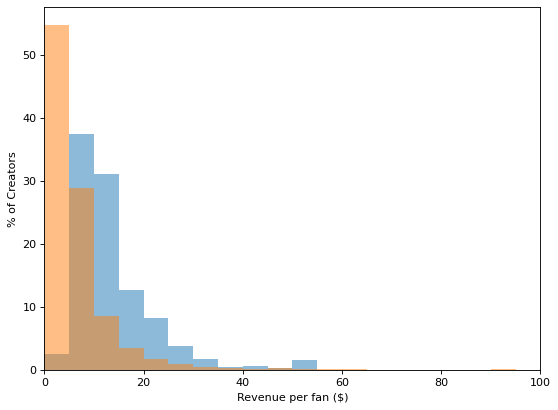

In [35]:
figure(figsize=(8, 6), dpi=80)

width=5
xlim = 100
hist1, bins1 = np.histogram(onlyfans.sub_price.dropna(),bins=np.arange(0,onlyfans.sub_price.max(),width))
plt.bar(bins1[:-1],100*hist1.astype(np.float32) / hist1.sum(), width=(width),color=onlyfans_color,alpha=0.5,align='edge')

hist2, bins2 = np.histogram(patreon.supportPerPatron.dropna(),bins=np.arange(0,patreon.supportPerPatron.max(),width))
plt.bar(bins2[:-1],100*hist2.astype(np.float32) / hist2.sum(), width=(width),color=patreon_color,alpha=0.5,align='edge')

# a.plot(kind='hist',bins=500,xlim=(0,10000),density=True)
# patreon.earnings.dropna().plot(kind='hist',bins=500,xlim=(0,10000))
plt.xlabel('Revenue per fan ($)')
plt.xlim(0,xlim)
plt.ylabel('% of Creators')

# plt.ylim(0,200)

Text(0, 0.5, '% of Creators')

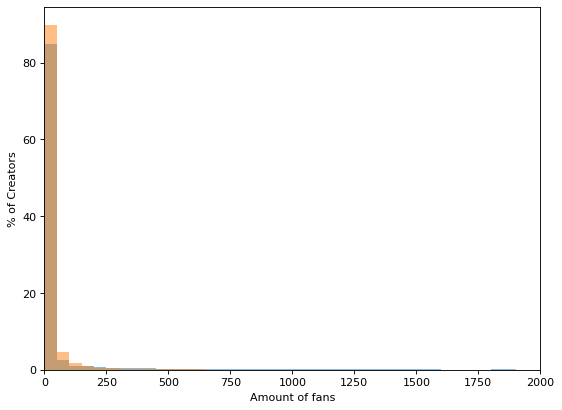

In [36]:
figure(figsize=(8, 6), dpi=80)

width=50
xlim = 2000
hist1, bins1 = np.histogram(onlyfans.fans.dropna(),bins=np.arange(0,onlyfans.fans.max(),width))
plt.bar(bins1[:-1],100*hist1.astype(np.float32) / hist1.sum(), width=(width),color=onlyfans_color,alpha=0.5,align='edge')

hist2, bins2 = np.histogram(patreon.patrons.dropna(),bins=np.arange(0,patreon.patrons.max(),width))
plt.bar(bins2[:-1],100*hist2.astype(np.float32) / hist2.sum(), width=(width),color=patreon_color,alpha=0.5,align='edge')

# a.plot(kind='hist',bins=500,xlim=(0,10000),density=True)
# patreon.earnings.dropna().plot(kind='hist',bins=500,xlim=(0,10000))
plt.xlabel('Amount of fans')
plt.xlim(0,xlim)
plt.ylabel('% of Creators')

# plt.ylim(0,200)

Text(0, 0.5, '% of Creators')

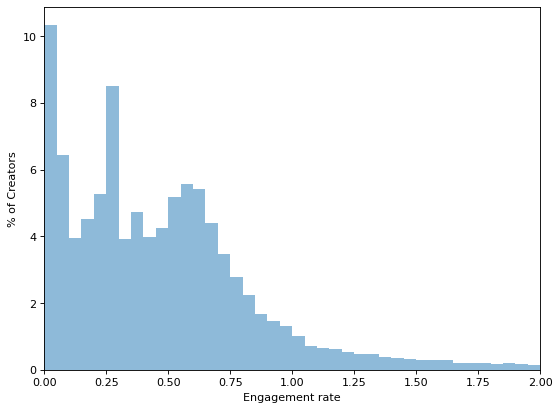

In [37]:
figure(figsize=(8, 6), dpi=80)

width=0.05
xlim = 2
hist1, bins1 = np.histogram(onlyfans.engagement_rate.dropna(),bins=np.arange(0,onlyfans.engagement_rate.max(),width))
plt.bar(bins1[:-1],100*hist1.astype(np.float32) / hist1.sum(), width=(width),color=onlyfans_color,alpha=0.5,align='edge')

# hist2, bins2 = np.histogram(patreon.patrons.dropna(),bins=range(0,xlim+width,width))
# plt.bar(bins2[:-1],100*hist2.astype(np.float32) / hist2.sum(), width=(width),color=patreon_color,alpha=0.5,align='edge')

# a.plot(kind='hist',bins=500,xlim=(0,10000),density=True)
# patreon.earnings.dropna().plot(kind='hist',bins=500,xlim=(0,10000))
plt.xlabel('Engagement rate')
plt.xlim(0,xlim)
plt.ylabel('% of Creators')

# plt.ylim(0,200)

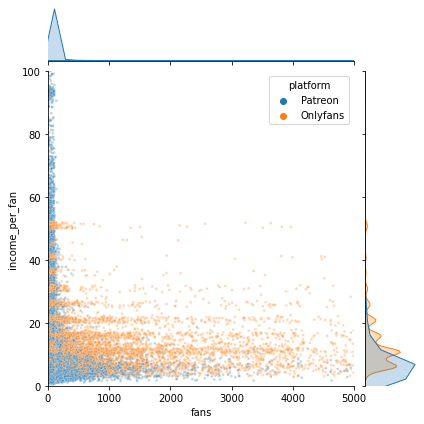

In [51]:
# TODO make histograms on the side, normalize them
combined_shuffled2 = combined_shuffled.copy(deep=True)

# we jitter the data a bit so it's more clear how "populated" a certain point is
# because Onlyfans sub price is always an integer, that makes it hard to see how many dots there are unless you add a tiny bit of noise
combined_shuffled2.fans += np.random.uniform(0,100,combined_shuffled2.fans.shape)
combined_shuffled2.income += np.random.uniform(0,250,combined_shuffled2.income.shape)
combined_shuffled2.income_per_fan += np.random.uniform(0,2,combined_shuffled2.income.shape)




sns.jointplot(data=combined_shuffled2,x='fans',y='income_per_fan',xlim=(0,5000),ylim=(0,100),hue='platform',palette=[onlyfans_color,patreon_color],marker=".",joint_kws={"s": 30,'alpha':0.3})

# joint_kws={"s": 20,'alpha':0.5}

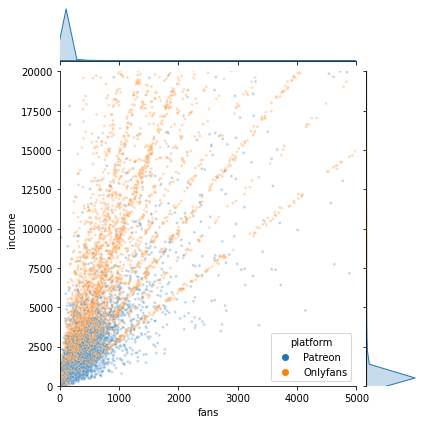

In [52]:
# TODO why is the margin plot only showing Patreon data?

sns.jointplot(data=combined_shuffled2,x='fans',y='income',xlim=(0,5000),ylim=(0,20000),hue='platform',palette=[onlyfans_color,patreon_color],marker=".",joint_kws={"s": 30,'alpha':0.3    })

# joint_kws={"s": 20,'alpha':0.5}

In [ ]:
sns.jointplot(data=onlyfans,x='fans',y='engagement_rate',xlim=(0,2000),ylim=(0,2),color=onlyfans_color,marker=".",joint_kws={"s": 30,'alpha':1})


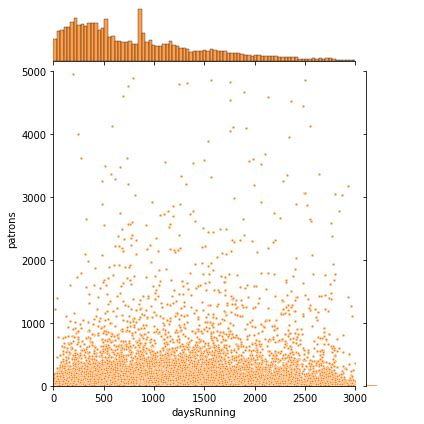

In [8]:

sns.jointplot(kind='scatter',data=patreon,x='daysRunning',y='patrons',xlim=(0,3000),ylim=(0,5000),color=patreon_color,marker=".",joint_kws={"s": 30,'alpha':1})


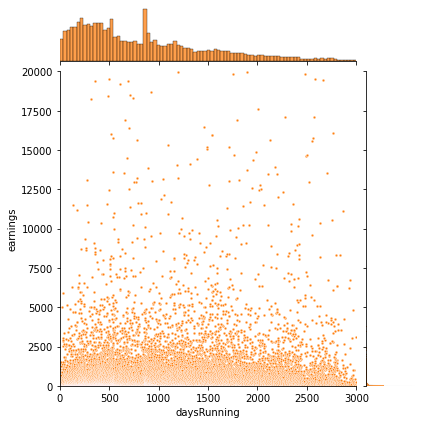

In [49]:
sns.jointplot(kind='scatter',data=patreon,x='daysRunning',y='earnings',xlim=(0,3000),ylim=(0,20000),color=patreon_color,marker=".",joint_kws={"s": 30,'alpha':1})



# Calculating indices and percentages of income

This bit is still from Thomas Hollands' original source code.

In [5]:
print("Onlyfans")
# what percentaige of revenue is top account?
total_rev = onlyfans['revenue'].sum()
num_acc = onlyfans['revenue'].count()
max_rev = onlyfans['revenue'].max()
top_10p = onlyfans['revenue'].nlargest(int(np.floor(onlyfans['revenue'].count()*0.10))).sum()
top_1p = onlyfans['revenue'].nlargest(int(np.floor(onlyfans['revenue'].count()*0.01))).sum()
top_20p = onlyfans['revenue'].nlargest(int(np.floor(onlyfans['revenue'].count()*0.2))).sum()
print("The top creator makes",np.round(100*max_rev/total_rev,2), "% of all income")
print('Top 10%:', np.round(100*top_10p/total_rev,2),"%")
print('Top 1%:', np.round(100*top_1p/total_rev,2),"%")
print('Top 20%:',np.round(100*top_20p/total_rev,2),"%")
# top 10% make 73% of the total revenue
# top 1% makes 57% of total revenue

print("\nPatreon")
# what percentaige of revenue is top account?
total_rev = patreon['earnings'].sum()
num_acc = patreon['earnings'].count()
max_rev = patreon['earnings'].max()
top_10p = patreon['earnings'].nlargest(int(np.floor(patreon['earnings'].count()*0.10))).sum()
top_1p = patreon['earnings'].nlargest(int(np.floor(patreon['earnings'].count()*0.01))).sum()
top_20p = patreon['earnings'].nlargest(int(np.floor(patreon['earnings'].count()*0.2))).sum()
print("The top creator makes",np.round(100*max_rev/total_rev,2), "% of all income")
print('Top 10%:', np.round(100*top_10p/total_rev,2),"%")
print('Top 1%:', np.round(100*top_1p/total_rev,2),"%")
print('Top 20%:',np.round(100*top_20p/total_rev,2),"%")
# top 10% make 73% of the total revenue
# top 1% makes 57% of total revenue

Onlyfans
The top creator makes 2.36 % of all income
Top 10%: 95.66 %
Top 1%: 57.25 %
Top 20%: 97.85 %

Patreon
The top creator makes 0.75 % of all income
Top 10%: 75.5 %
Top 1%: 38.24 %
Top 20%: 86.7 %


# Calculating Gini index for Onlyfans and Patreon

The higher this index is, the higher the inequality in a society is. For example, the country with the highest Gini index, South Africa, has an index of 63. The US has a Gini index of 41.4 or 47 (depending on whether you ask the world bank or the CIA), the EU has a Gini of ~30. Slovenia has the lowest Gini index, of 23 to 24.

Income inequality on Patreon and Onlyfans is much worse, as you will see below.

This bit is still from Thomas Hollands' original source code.

In [6]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return 100*((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

print("Onlyfans Gini coefficient")
print(gini(np.array(onlyfans['revenue'].dropna())))

print("\nPatreon Gini coefficient")
print(gini(np.array(patreon['earnings'].dropna())))
# gini coefficient of 0.89

Onlyfans Gini coefficient
94.73502800931844

Patreon Gini coefficient
83.4907029794498


# Estimating yearly revenue of the companies

In [7]:
# get total revenue of onlyfans
n_creators = 0.75e6 # half of stated in https://famemass.com/onlyfans-statistics/
rev_per_creator = onlyfans['revenue'].mean() * 0.2
total_rev_month = n_creators * rev_per_creator
total_rev = total_rev_month * 12
print('Top-down estimate of yearly Onlyfans revenue is: $',np.round(total_rev / 1e9,2),"B")
# bottom up calc
n_paying_users = 75e6 # half of 150m users, extrapolated from https://famemass.com/onlyfans-statistics/
mean_sub_price = onlyfans['sub_price'].mean() 
monthly_rev = mean_sub_price*n_paying_users * 0.2
yearly_rev = 12 * monthly_rev
print('Bottom-up estimate of yearly Onlyfans revenue is: $',np.round(yearly_rev / 1e9,2),"B")


print("\n")

# get total revenue of patreon
# Patreon takes 5%, 8% or 12% of your income depending on your account plan
# 8% is probably the most common
n_creators = 187000 # more than 187000 are supported by at least one Patron https://backlinko.com/patreon-users
rev_per_creator = patreon.earnings.mean() * 0.08
total_rev_month = n_creators * rev_per_creator
total_rev = total_rev_month * 12
print('Top-down estimate of yearly Patreon revenue is: $',np.round(total_rev / 1e6,2),"M")
# bottom up calc
n_paying_users = 6e6 # 6m monthly active supporters https://backlinko.com/patreon-users
mean_sub_price = patreon.supportPerPatron.mean()
monthly_rev = mean_sub_price*n_paying_users * 0.08
yearly_rev = 12 * monthly_rev
print('Bottom-up estimate of yearly Patreon revenue is: $',np.round(yearly_rev / 1e6,2),"M")



Top-down estimate of yearly Onlyfans revenue is: $ 4.85 B
Bottom-up estimate of yearly Onlyfans revenue is: $ 2.17 B


Top-down estimate of yearly Patreon revenue is: $ 32.03 M
Bottom-up estimate of yearly Patreon revenue is: $ 39.91 M


These numbers make sense.

As per [this article](https://www.statista.com/chart/25625/onlyfans-projected-revenue-and-gmv/), "OnlyFans expected gross merchandise value to grow from $2.2 billion in 2020 to $12.5 billion next year, with net revenue also expected to increase more than five-fold to $2.5 billion by 2022."

Patreon revenue was estimated to be [$70M](https://growjo.com/company/Patreon) to [$80M](https://backlinko.com/patreon-users) in 2020, so we are a bit on the low side.